<a href="https://colab.research.google.com/github/SaiSamyuktaP/NeuralStyleTransfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
from builtins import range, input

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [ ]:
def VGG16AvgPool(shape):
  vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top = False)
  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)
  return new_model

In [ ]:
def VGG16AvgPool_Cutoff(shape, num_convs):
  num = 0
  output = None
  VGGmodel = VGG16AvgPool(shape)
  for layer in VGGmodel.layers:
    if layer.__class__ == Conv2D:
      num += 1
    if num == num_convs:
      output = layer.output
      break

  return Model(VGGmodel.input, output)

In [ ]:
img = image.load_img('elephant.jpg')

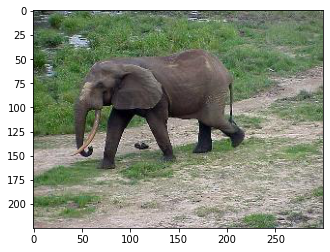

In [ ]:
plt.imshow(img)

In [ ]:
#Convert to numpy array
img_arr = np.array(img)
img_arr.shape

(225, 300, 3)

In [ ]:
#Expand dimensions for model
x = np.expand_dims(img_arr, 0)

In [ ]:
#Preprocess the input
x = preprocess_input(x)

In [ ]:
batch_size = x.shape
shape = x.shape[1:]

In [ ]:
content_model = VGG16AvgPool_Cutoff(shape, 11)

In [ ]:
target = K.variable(content_model.predict(x))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
type(target)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [ ]:
target.shape

TensorShape([1, 14, 18, 512])

In [ ]:
# define our loss in keras
loss = K.mean(K.square(target - content_model.output))

In [ ]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [ ]:
# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b


import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [ ]:
def VGG16_AvgPool(shape):
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

In [ ]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  model = VGG16_AvgPool(shape)
  
  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)

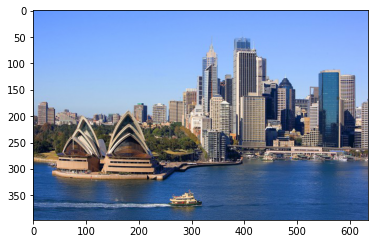

In [ ]:
# open an image
path = 'sydney.jpg'
img = image.load_img(path)

# convert image to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# we'll use this throughout the rest of the script
batch_shape = x.shape
shape = x.shape[1:]

# see the image
plt.imshow(img)
plt.show()

In [ ]:
# make a content model
# try different cutoffs to see the images that result
content_model = VGG16_AvgPool_CutOff(shape, 9)

# make the target
target = K.variable(content_model.predict(x))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 397, 635, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 397, 635, 3), dtype=float32)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# try to match the image

# define our loss in keras
loss = K.mean(K.square(target - content_model.output))

# gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[content_model.input],
  outputs=[loss] + grads
)

In [ ]:
def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


iter=0, loss=9948.330078125
iter=1, loss=4438.744140625
iter=2, loss=2851.635986328125
iter=3, loss=2136.103515625
iter=4, loss=1759.2762451171875
iter=5, loss=1530.6024169921875
iter=6, loss=1378.0462646484375
iter=7, loss=1268.205322265625
iter=8, loss=1183.3409423828125
iter=9, loss=1114.900634765625
duration: 0:00:37.868609


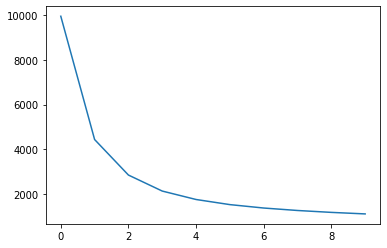

In [ ]:
from datetime import datetime
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
  x, l, _ = fmin_l_bfgs_b(
    func=get_loss_and_grads_wrapper,
    x0=x,
    # bounds=[[-127, 127]]*len(x.flatten()),
    maxfun=20
  )
  x = np.clip(x, -127, 127)
  # print("min:", x.min(), "max:", x.max())
  print("iter=%s, loss=%s" % (i, l))
  losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

In [ ]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [ ]:
newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

In [ ]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

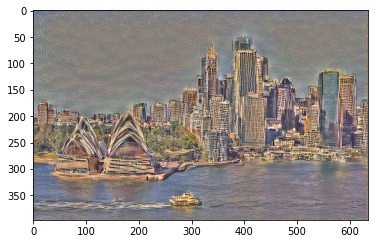

In [ ]:
plt.imshow(scale_img(final_img[0]))
plt.show()